<a href="https://colab.research.google.com/github/kmusayeva/GlobalAMFPred/blob/main/GlobalAMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of global database of arbuscular mycorrhizal fungal (AMF) occurrences

This notebook provides some analysis (still ongoing) as well as prediction of GlobalAMF data obtained from [the site](https://globalamfungi.com). These data have been gathered and processed by Vetrovsky et al.<sup>[1](#ref1)</sup>. This is a non-homogenous dataset comprising of observations coming from different sources with different experimental design and study purposes. Despite the possible noise and bias, we make an attempt to predict AMF species from environmental variables. This is done in the multi-label classification setting, where one location with its pedo-climatic conditions is associated with multiple species/labels.

At the first step, we keep almost all variables that the data come with: most of these variables are categorical and not relevant to environmental conditions, such as paper_id. We use classifiers such as LightGBM, XGBoost and CatBoost suitable particularly for huge categorical data (such as plants) to gain insight into the variable importance.

At the second step, we drop irrelevant variables, and apply and compare multitude of multi-label classification methods most of which work with real-valued data. These are all non-parametric methods.

## Install/import libraries



In [ ]:
!pip install optuna
!pip install shap
!pip install scikit-multilearn
!pip install catboost
!pip install liac-arff
!python -m pip install autogluon

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import os
import optuna
import logging
import warnings


In [59]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

warnings.filterwarnings("ignore", category=UserWarning)

## Read the data

In [6]:
df = pd.read_excel("all.xlsx")

Input variables:

In [7]:
X_cols = ['paper_id', 'primers', 'longitude', 'latitude', 'continent',
         'sample_type', 'marker_size', 'Biome', 'MAT', 'MAP', 'pH', 'year_of_sampling',
        'plants_dominant', 'target_gene', 'sequencing_platform']


Species:

In [8]:
Y_cols = df.columns[len(X_cols):]

## Prepare and analyze the data

We remove marker_size, primers, and years_of_sampling input variables:

In [9]:
X_cols_selected = ['paper_id', 'longitude', 'latitude', 'continent',
       'sample_type', 'Biome', 'plants_dominant', 'target_gene',
       'sequencing_platform', 'MAP', 'MAT', 'pH']

df2 = df[X_cols_selected + Y_cols.tolist()]

There are 69 papers, more than 4000 lines with duplicates. We will do
aggregation later.

In [8]:
print(f"The number of unique papers: {df2['paper_id'].nunique()}, the total number of lines: {len(df2)}.")

The number of unique papers: 69, the total number of lines: 4105.


How many species/labels?

In [140]:
print(f"There are {len(Y_cols)} species/labels.")

There are 64 species/labels.


Since this dataset combines many different studies, in some cases many plants are gathered as an ensemble into one observation, in other studies different plants associated with a single location is separated into separate lines. For prediction purposes, we will separate the plants associated with a single observation into separate lines.

In [10]:
df2.loc[:, "plants_dominant"] = df2["plants_dominant"].str.split(";")

df3 = df2.explode("plants_dominant", ignore_index=True)

Next we do aggregation:

In [11]:
df3 = df3.groupby(X_cols_selected).mean().reset_index()

df3.shape

(2396, 76)

We remove the species with zero occurence (this happened due to the preprocessing, where the observations with NAs in environmental variables are removed leaving several species columns with all zeroes): there are only three such species:

In [13]:
Y_cols[(df3[Y_cols]==0).all()]

Index(['Septoglomus nigrum', 'Cetraspora_gilmorei',
       'Funneliglomus sanmartinense'],
      dtype='object')

In [12]:
Y_cols_selected = Y_cols[df3[Y_cols].sum(axis=0)>0]


We convert abundancies to presence/absence data, i.e., to 1/0:


In [13]:
df3 = df3[X_cols_selected+Y_cols_selected.tolist()]

df3.loc[:,Y_cols_selected] = np.where(df3[Y_cols_selected]>0, 1, df3[Y_cols_selected])

Let us have a look at the resulting dataset:

In [16]:
df3.head(10)

,paper_id,longitude,latitude,continent,sample_type,Biome,plants_dominant,target_gene,sequencing_platform,MAP,...,Diversispora varaderana,Claroideoglomus_lamelossum,Dentiscutata_heterogama,Dominikia minuta,Diversispora peridiata,Acaulospora_alpina,Dominikia indica,Acaulospora_viridis,Funneliformis mosseae,Diversispora eburnea
0,Badi_2019_1AC,32.7611,13.1010,Africa,root,cropland,Sorghum bicolor,SSU,IonTorrent,333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Boeraeve_2019_1AJ,4.9041,50.8658,Europe,soil,forest,Alnus glutinosa,SSU,Illumina,751,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Boeraeve_2019_1AJ,4.9362,50.8512,Europe,soil,forest,Alnus glutinosa,SSU,Illumina,731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Boeraeve_2019_1AJ,4.9365,50.8512,Europe,soil,forest,Alnus glutinosa,SSU,Illumina,731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Boeraeve_2019_1AJ,4.9366,50.8498,Europe,soil,forest,Alnus glutinosa,SSU,Illumina,739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Boeraeve_2019_1AJ,4.9367,50.8500,Europe,root,forest,Alnus glutinosa,SSU,Illumina,731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Boeraeve_2019_1AJ,4.9604,50.8625,Europe,soil,forest,Alnus glutinosa,SSU,Illumina,741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Boeraeve_2019_1AJ,4.9605,50.8612,Europe,soil,forest,Alnus glutinosa,SSU,Illumina,741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Boeraeve_2019_1AJ,4.9605,50.8624,Europe,root,forest,Alnus glutinosa,SSU,Illumina,741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Boeraeve_2019_1AJ,4.9608,50.8609,Europe,soil,forest,Alnus glutinosa,SSU,Illumina,741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We need to check if there are rows in species data with all zeroes:

In [14]:
assert sum(df3.loc[:,Y_cols_selected].sum(axis=1)==0)==0

### Same location, many samples

How many different sample types are there:

In [15]:
df3.groupby(["sample_type"])["plants_dominant"].agg([("count", "count")]).sort_values("count", ascending=False)

,count
sample_type,
soil,1267
root,974
rhizosphere soil,114
topsoil,32
sediment,9


Are there different sample types associated with a single location:

In [16]:
grouped = df3.groupby(["longitude", "latitude"])
sample_types = grouped["sample_type"].apply(set).reset_index()
sample_types_location = sample_types[sample_types["sample_type"].apply(lambda x: len(x)>1)]
print(f"There are {len(sample_types_location)} such locations: \
{round(len(sample_types_location)*100/len(grouped), 1)}% of total number of unique locations.")

There are 119 such locations: 15.1% of total number of unique locations.


For these locations, the frequency of combination of sample types:

In [20]:
sample_types.loc[sample_types["sample_type"].apply(lambda x: len(x)>1), "sample_type"]\
.value_counts()


,count
sample_type,
"{rhizosphere soil, soil}",45
"{root, soil}",43
"{root, topsoil}",30
"{rhizosphere soil, root}",1


Now, let us now have a glimpse on how many samples are taken from a single location:

In [17]:
repeated_samples = df3.groupby(["longitude", "latitude", "sample_type"]).size().sort_values(ascending=False)
repeated_samples.name = "count"
repeated_samples.head(10)

,,,count
longitude,latitude,sample_type,
14.4892,52.4630,soil,37
-73.9400,45.4300,root,37
-73.3700,45.7200,rhizosphere soil,33
112.2900,35.2000,soil,24
-113.9840,46.6900,root,22
16.9740,48.2010,root,21
-113.8760,49.0857,root,21
-113.8500,49.1287,root,19
-113.9890,46.6780,root,18


The question is what variables are different for these locations? Let us look a bit closer at some of these locations:

#### First observation

In [134]:
obs1 = df3.loc[(df3["longitude"] == -73.9400) & (df3["latitude"] == 45.4300), ]
obs1[X_cols_selected].head(5)

,paper_id,longitude,latitude,continent,sample_type,Biome,plants_dominant,target_gene,sequencing_platform,MAP,MAT,pH
389,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,4.89
390,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,5.19
391,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,5.20
392,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,5.27
393,DeBellis_2019_EH,-73.94,45.43,North America,root,forest,Acer platanoides,SSU,Illumina,1025,7.3,5.44


First, we see that there are two plants occuring repeatedly:

In [ ]:
obs1["plants_dominant"].value_counts()

,count
plants_dominant,
Acer saccharum,19
Acer platanoides,18


Secondly, **the variable that is different for these repeated samples is pH**.


How much does the pH associated with this single location vary?

In [65]:
obs1["pH"].describe()

,pH
count,37.000000
mean,5.754324
std,0.389612
min,4.890000
25%,5.440000
50%,5.770000
75%,6.070000
max,6.470000


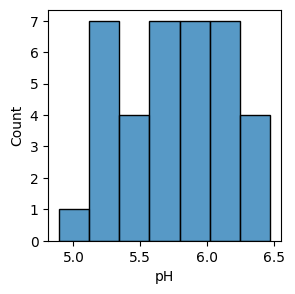

In [129]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.histplot(obs1["pH"], ax=ax)
plt.show()

Moreover, **there is only one species** classified for this study as per analysis by Vetrovsky et al., 2023.

In [ ]:
Y_cols_selected[(obs1[Y_cols_selected].sum(axis=0)>0).tolist()][0]

'Diversispora epigaea'

The paper associated with this particular study is: Tonia de Bellis et al., 2019. "Shared mycorrhizae but distinct communities of other root-associated microbes on co-occurring native and invasive maples.". From the paper, one can see that the authors took samples from 5 parallel transects on 8 different dates, however only a single latitudinal and longitudinal coordinate is specified.

#### Second observation

In the study below , there is one plant, but again different pH values:

In [135]:
obs2 = df3.loc[(df3["longitude"] == 14.4892) & (df3["latitude"] == 52.4630), ]
obs2[X_cols_selected].head(5)


,paper_id,longitude,latitude,continent,sample_type,Biome,plants_dominant,target_gene,sequencing_platform,MAP,MAT,pH
693,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,5.58
694,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,5.70
695,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,5.84
696,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,6.12
697,Horn_2014_B890,14.4892,52.463,Europe,soil,grassland,Festuca brevipila,LSU,454Roche,481,9.4,6.34


Distribution of pH:

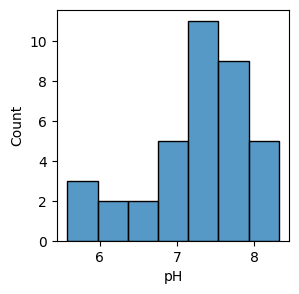

In [132]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.histplot(obs2["pH"], ax=ax)
plt.show()

Species related to this observation:

In [68]:
Y_cols_selected[(obs2[Y_cols_selected].sum(axis=0)>0).tolist()].tolist()

['Rhizophagus irregularis',
 'Septoglomus viscosum',
 'Claroideoglomus_claroideum',
 'Claroideoglomus_candidum',
 'Ambispora_gerdemannii',
 'Glomus macrocarpum',
 'Septoglomus constrictum',
 'Diversispora insculpta',
 'Dominikia minuta',
 'Dominikia indica']

#### Third observation

The objective of this paper: "The study explores how arbuscular mycorrhizal fungi (AMF) communities are structured in the rhizosphere of willow plants (Salix spp.) grown in hydrocarbon-contaminated versus uncontaminated soils."  With the finding: "Hydrocarbon contamination strongly affects AMF community composition.
Highly contaminated soils are dominated by a small group of AMF taxa, primarily in the genus Rhizophagus, while uncontaminated and moderately contaminated soils have more diverse AMF communities."

The site is divided into two areas:
Uncontaminated area: Blocks N1, N3, and N5.
Contaminated area: Blocks C3, C4, and C5.
These are further classified into:
Low contamination (LC): Block C3.
High contamination (HC): Blocks C4 and C5.
Each block contains 25 m² plots where soil and rhizosphere samples were collected from planted willows or unplanted control areas.

In [136]:
obs3 = df3.loc[(df3["longitude"] == -73.3700) & (df3["latitude"] == 45.7200), ]
obs3[X_cols_selected].head(5)


,paper_id,longitude,latitude,continent,sample_type,Biome,plants_dominant,target_gene,sequencing_platform,MAP,MAT,pH
649,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix acutifolia,SSU,454Roche,1020,7.2,5.4
650,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix acutifolia,SSU,454Roche,1020,7.2,5.6
651,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix acutifolia,SSU,454Roche,1020,7.2,6.7
652,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix alba,SSU,454Roche,1020,7.2,5.4
653,Hassan_2014_0837,-73.37,45.72,North America,rhizosphere soil,grassland,Salix alba,SSU,454Roche,1020,7.2,5.6


pH values:

In [ ]:
obs3["pH"].describe()

,pH
count,33.000000
mean,6.157576
std,0.677325
min,5.400000
25%,5.600000
50%,6.500000
75%,6.700000
max,7.400000


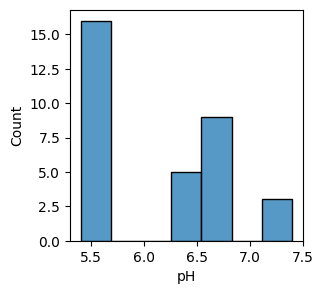

In [137]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.histplot(obs3["pH"], ax=ax)
plt.show()

Species:

In [ ]:
Y_cols_selected[(obs3[Y_cols_selected].sum(axis=0)>0).tolist()][0]

'Diversispora epigaea'

### Which study has the largest number of observations?

In [24]:
group_paper = df3.groupby("paper_id").size().sort_values(ascending=False)
group_paper.name = "size"
group_paper.head(10)

,size
paper_id,
Xiang_2014_BD5B,488
Davison_2015_1GM,138
Rezacova_2021_1HU,135
Morgan_2017_1CJ,120
Fan_2020_1GN,90
Wall_2020_1HX,89
Stover_2018_1DI,88
Lekberg_2013_37D2,84
Rasmussen_2018_C8E6,59


The largest number of observations corresponds to Xiang_2014_BD5B: **488 observations with 50 unique locations and 14 different plants**. Let us take a look at these observations:

In [25]:
Xiang_2014_BD5B = df3[df3["paper_id"] == "Xiang_2014_BD5B"]
Xiang_2014_BD5B.head()

,paper_id,longitude,latitude,continent,sample_type,Biome,plants_dominant,target_gene,sequencing_platform,MAP,...,Diversispora varaderana,Claroideoglomus_lamelossum,Dentiscutata_heterogama,Dominikia minuta,Diversispora peridiata,Acaulospora_alpina,Dominikia indica,Acaulospora_viridis,Funneliformis mosseae,Diversispora eburnea
1815,Xiang_2014_BD5B,102.071,36.4503,Asia,soil,cropland,Zea mays,SSU,454Roche,382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1816,Xiang_2014_BD5B,102.071,36.4503,Asia,soil,grassland,Artemisia capillaris,SSU,454Roche,382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1817,Xiang_2014_BD5B,102.071,36.4503,Asia,soil,grassland,Artemisia frigida,SSU,454Roche,382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1818,Xiang_2014_BD5B,102.071,36.4503,Asia,soil,grassland,Carex humilis,SSU,454Roche,382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1819,Xiang_2014_BD5B,102.071,36.4503,Asia,soil,grassland,Carex onoei,SSU,454Roche,382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This study concerns Asia. The number of unique locations this study dealt with:


In [26]:
len(Xiang_2014_BD5B.groupby(["longitude", "latitude"]).size())

50

How many different plants?

In [27]:
Xiang_2014_BD5B_plants = Xiang_2014_BD5B["plants_dominant"].value_counts()
print(f"There are {Xiang_2014_BD5B_plants.shape[0]} different plants:\n")
print(Xiang_2014_BD5B_plants)

There are 14 different plants:

plants_dominant
Zea mays                  46
Artemisia capillaris      34
Artemisia frigida         34
Carex humilis             34
Carex onoei               34
Cenchrus incertus         34
Chloris virgata           34
Cleistogenes squarrosa    34
Heteropappus altaicus     34
Lespedeza davurica        34
Leymus chinensis          34
Setaria viridis           34
Stipa caucasica           34
Tribulus terrestris       34
Name: count, dtype: int64


How many different species?


In [29]:
species_sums = Xiang_2014_BD5B[Y_cols_selected].sum(axis=0)
species_present = species_sums[species_sums > 0]
species_present.name = "count"

print(f"There are {len(species_present)} different species:\n")
print(species_present.sort_values(ascending=False))


There are 12 different species:

Rhizophagus intraradices       351.0
Septoglomus viscosum           217.0
Funneliformis mosseae           55.0
Diversispora trimurales         45.0
Ambispora_fennica               43.0
Diversispora epigaea            33.0
Funneliformis coronatus         33.0
Rhizophagus microaggregatum     31.0
Gigaspora decipiens             15.0
Funneliformis caledonius         3.0
Rhizophagus prolifer             1.0
Archaeospora_trappei             1.0
Name: count, dtype: float64


Let us have a look at plant - species association, as well as other variables:

In [32]:
selected_columns = Xiang_2014_BD5B[species_present.index]
Xiang_2014_BD5B.loc[:, 'species_list'] = selected_columns.apply(lambda row: list(row.index[row != 0]), axis=1)
result = Xiang_2014_BD5B[['plants_dominant', 'longitude', 'latitude','pH','species_list']].sort_values(by=["plants_dominant", "pH"])
result["species_count"] = result["species_list"].apply(lambda x: len(x))
result.sort_values(by=["species_count"], ascending=False)

,plants_dominant,longitude,latitude,pH,species_list,species_count
2090,Zea mays,114.326,41.0846,7.30,"[Diversispora epigaea, Ambispora_fennica, Sept...",6
1815,Zea mays,102.071,36.4503,7.55,"[Diversispora epigaea, Archaeospora_trappei, D...",5
2062,Zea mays,112.996,40.9957,8.23,"[Septoglomus viscosum, Diversispora trimurales...",5
1847,Carex onoei,102.826,36.3530,8.42,"[Septoglomus viscosum, Funneliformis coronatus...",4
1848,Cenchrus incertus,102.826,36.3530,8.42,"[Septoglomus viscosum, Funneliformis coronatus...",4
...,...,...,...,...,...,...
1907,Lespedeza davurica,104.868,36.9917,8.63,[Rhizophagus intraradices],1
1937,Lespedeza davurica,106.389,36.6687,8.63,[Rhizophagus intraradices],1
1861,Carex onoei,103.469,35.4489,8.12,[Funneliformis mosseae],1
1972,Lespedeza davurica,109.756,39.4960,10.13,[Diversispora epigaea],1


## Plant based analysis

### Common wheat

Triticum aestivum, i.e., common wheat is the most studied plant with total of 120 observations, followed by corn with 81 studies:

In [33]:
df3["plants_dominant"].value_counts()

,count
plants_dominant,
Triticum aestivum,120
Zea mays,81
Plantago lanceolata,65
Eragostis tef,52
Theobroma cacao,47
...,...
Thalictrum foetidum,1
Ranunculus pedatifidus,1
Poa attenuata,1


In [40]:
wheat = df3.loc[df3["plants_dominant"].str.contains("Triticum aestivum")]

How many continents for wheat?

In [37]:
wheat["continent"].value_counts()

,count
continent,
Asia,95
Europe,28
North America,2


Distribution of pH for wheat:

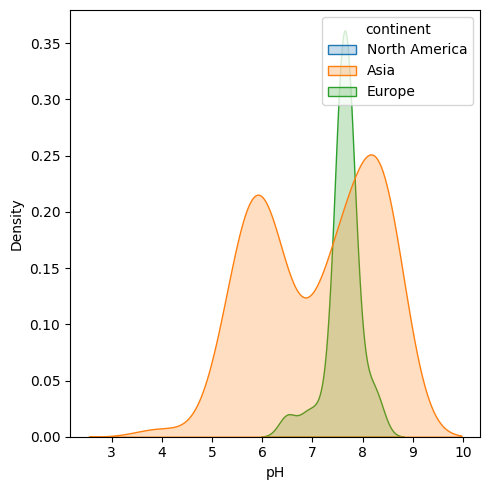

In [139]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(data=wheat, x='pH', hue='continent', fill=True, warn_singular=False, ax=ax)
plt.tight_layout()

North America is visible in the following frequency plot:

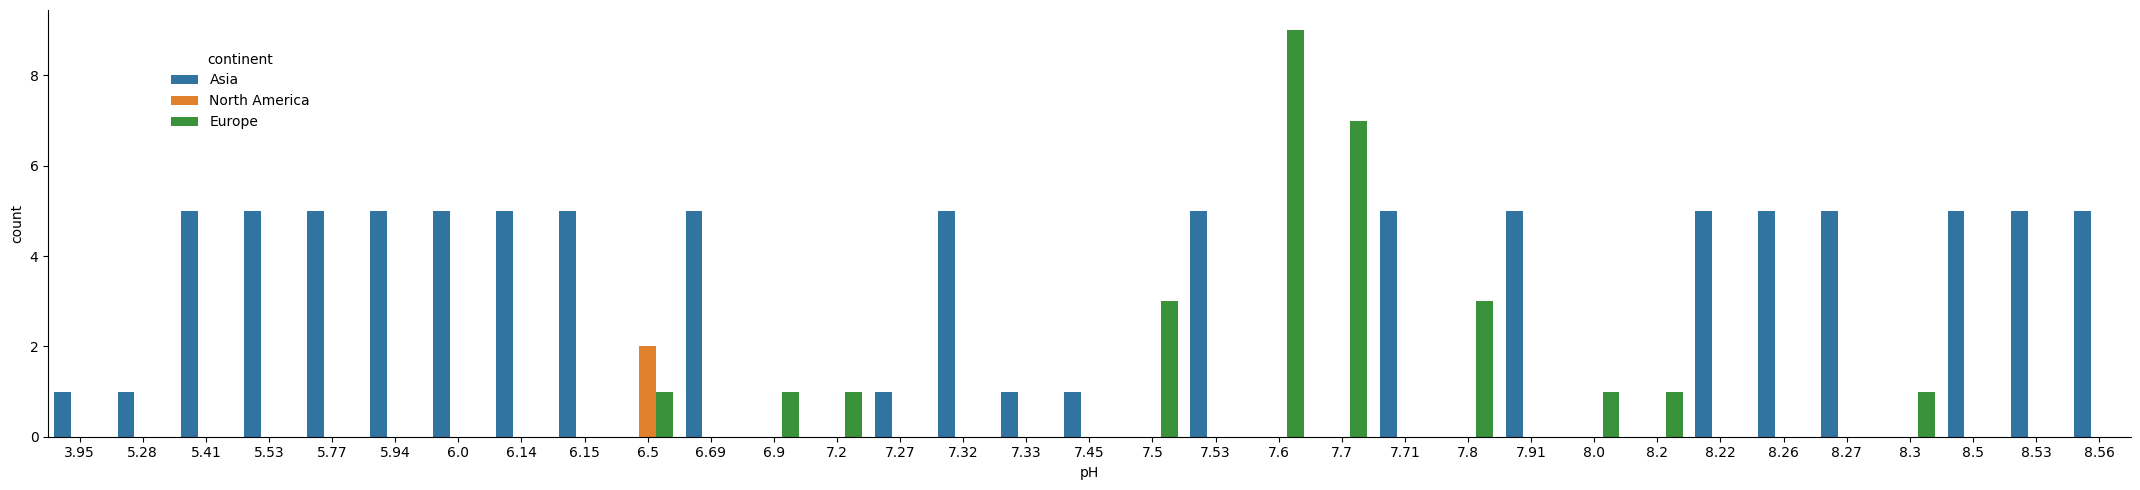

In [39]:
plot = sns.catplot(data=wheat, x='pH', kind='count', hue='continent', aspect=4.0)

plot.legend.set_bbox_to_anchor((0.15, 0.9))
plot.legend.set_loc('upper right')

plt.tight_layout()
plt.show()

The number of species associated:

In [41]:
wheat_species_sum = wheat[Y_cols_selected].sum(axis=0)

wheat_species_present = wheat_species_sum[wheat_species_sum > 0]

wheat_species_present.name = "count"

print(f"There are {len(wheat_species_present)} species:\n")

print(wheat_species_present.sort_values(ascending=False))


There are 16 species:

Funneliformis caledonius      120.0
Rhizophagus intraradices       92.0
Rhizophagus manihotis          90.0
Septoglomus viscosum           85.0
Archaeospora_trappei           81.0
Funneliformis mosseae          62.0
Gigaspora decipiens            41.0
Rhizophagus clarus             17.0
Ambispora_gerdemannii          14.0
Rhizophagus irregularis         6.0
Claroideoglomus_claroideum      6.0
Glomus macrocarpum              3.0
Cetraspora_nodosa               2.0
Diversispora epigaea            2.0
Diversispora trimurales         2.0
Claroideoglomus_candidum        1.0
Name: count, dtype: float64


Species list for each location:

In [42]:
wheat_species_list = wheat[wheat_species_present.index].apply(lambda row:list(row.index[row!=0]), axis=1)
wheat_species_list.name = "species_list"
species_count = wheat_species_list.apply(lambda x: len(x)).rename("count")
wheat_species_list_location = wheat.loc[wheat_species_list.index, ["continent", "longitude", "latitude", "pH"]].join([wheat_species_list, species_count])
wheat_species_list_location.sort_values(by=["count"], ascending=False)

,continent,longitude,latitude,pH,species_list,count
538,Asia,114.9790,36.2842,8.56,"[Rhizophagus manihotis, Archaeospora_trappei, ...",8
537,Asia,114.9790,36.2842,7.91,"[Cetraspora_nodosa, Rhizophagus manihotis, Arc...",8
570,Asia,117.6760,36.9843,8.50,"[Rhizophagus manihotis, Archaeospora_trappei, ...",7
557,Asia,117.0000,35.0052,5.41,"[Rhizophagus manihotis, Archaeospora_trappei, ...",7
554,Asia,115.6280,33.2259,8.22,"[Rhizophagus manihotis, Archaeospora_trappei, ...",7
...,...,...,...,...,...,...
1416,Europe,6.2555,50.8461,7.70,[Funneliformis caledonius],1
1762,Asia,111.8700,26.7628,3.95,[Rhizophagus manihotis],1
952,Europe,13.0333,55.7333,8.30,[Funneliformis mosseae],1
1412,Europe,6.2482,50.8680,7.60,[Ambispora_gerdemannii],1


### Which plant and pH combination have the most and the least number of species?

Artemisia vulgaris has the largest number, 20 species associated with it, and many plants/pH have just 1.

In [46]:
species_count = df3[Y_cols_selected].apply(lambda row:len(list(row.index[row!=0])), axis=1).rename("count")
plant_ph_species = df3[["longitude", "latitude", "pH", "plants_dominant", "continent"]].join(species_count).sort_values(by=["count"], ascending=False)
print(plant_ph_species)

      longitude  latitude    pH         plants_dominant      continent  count
1271    16.9600   49.7354  7.41      Artemisia vulgaris         Europe     20
1264    14.8917   50.2486  7.38       Tanacetum vulgare         Europe     18
1276    16.9600   49.7357  7.51      Artemisia vulgaris         Europe     17
1263    14.8917   50.2486  7.38         Erigeron annuus         Europe     16
1248    14.6514   50.5714  6.42           Daucus carota         Europe     15
...         ...       ...   ...                     ...            ...    ...
1669  -155.3260   19.8215  4.70  Cheirodendron trigynum  North America      1
1671  -155.3260   19.8215  4.40     Myrsine lessertiana  North America      1
1672  -155.3260   19.8215  4.80     Myrsine lessertiana  North America      1
172    107.4100   35.1200  8.00  Platycladus orientalis           Asia      1
1571  -113.8510   49.1295  7.80     Heterotheca villosa  North America      1

[2396 rows x 6 columns]


In [48]:
plant_ph_species[plant_ph_species["count"]==1]

,longitude,latitude,pH,plants_dominant,continent,count
1010,-87.3501,20.4443,8.34,Manilkara zapota,North America,1
1902,104.8680,36.9917,8.63,Carex onoei,Asia,1
108,-113.9870,46.6770,7.70,Heterotheca villosa,North America,1
1012,-87.3501,20.4443,8.34,Vachellia cornigera,North America,1
2048,112.0580,39.0587,8.17,Zea mays,Asia,1
...,...,...,...,...,...,...
1669,-155.3260,19.8215,4.70,Cheirodendron trigynum,North America,1
1671,-155.3260,19.8215,4.40,Myrsine lessertiana,North America,1
1672,-155.3260,19.8215,4.80,Myrsine lessertiana,North America,1
172,107.4100,35.1200,8.00,Platycladus orientalis,Asia,1


### Rare species

Let us now look at species with rare occurences:

In [49]:
df3[Y_cols_selected].sum(axis=0).sort_values().head(20)

,0
Desertispora_omaniana,1.0
Acaulospora_viridis,1.0
Ambispora_granatensis,2.0
Acaulospora_pustulata,2.0
Dominikia iranica,2.0
Acaulospora_colossica,3.0
Acaulospora_alpina,3.0
Septoglomus mediterraneum,3.0
Dentiscutata_erythropus,4.0
Gigaspora rosea,4.0




Let us take species with less than 20 observations:


In [50]:
rare_species = Y_cols_selected[(df3[Y_cols_selected].sum(axis=0)<20)]

rare_species

Index(['Dominikia disticha', 'Acaulospora_colossica', 'Acaulospora_minuta',
       'Acaulospora_pustulata', 'Archaeospora_ecuadoriana',
       'Acaulospora_cavernata', 'Diversispora celata', 'Dominikia iranica',
       'Claroideoglomus_candidum', 'Septoglomus mediterraneum',
       'Ambispora_granatensis', 'Gigaspora rosea', 'Rhizophagus proliferus',
       'Desertispora_omaniana', 'Dentiscutata_erythropus',
       'Diversispora insculpta', 'Claroideoglomus_lamelossum',
       'Dominikia minuta', 'Acaulospora_alpina', 'Acaulospora_viridis',
       'Diversispora eburnea'],
      dtype='object')

Where do they appear?

In [51]:
df3.loc[df3[rare_species].sum(axis=1) > 0, ["continent"]].value_counts()

,count
continent,
Europe,90
North America,31
South America,2


Which plants?

In [52]:
df3.loc[df3[rare_species].sum(axis=1) > 0, ["plants_dominant"]].value_counts()

,count
plants_dominant,
Daucus carota,14
Arrhenatherum elatius,14
Hordeum vulgare,12
Medicago sativa,8
Acacia koa,7
Metrosideros polymorpha,7
Festuca brevipila,6
Tanacetum vulgare,5
Centaurea stoebe,4


## Prediction

### Which species?

There are around 60 species, but most are rare. These rare species can not be used for prediction (nothing to learn from rare occurences) should be studied separately. The table below shows the relative frequency of species. We will select only top k most frequent species, where k may vary between 10 and 20.

In [18]:
rel_freq = df3[Y_cols_selected].sum(axis=0)*100/len(df3)
rel_freq.name = "RF"
rel_freq = rel_freq.sort_values(ascending=False)
rel_freq.head(10)

,RF
Rhizophagus intraradices,44.156928
Septoglomus viscosum,23.539232
Funneliformis mosseae,19.824708
Diversispora epigaea,14.649416
Funneliformis caledonius,13.188648
Gigaspora decipiens,13.063439
Rhizophagus irregularis,11.936561
Rhizophagus manihotis,11.727880
Archaeospora_trappei,11.310518
Diversispora trimurales,9.474124


In [19]:
k = 20
top_species = rel_freq.head(k).index
Y = df3[top_species]

In [21]:
X = df3[X_cols_selected]

Convert the of categorical variables  into category data type:

In [23]:
for col in X.columns:
     if X[col].dtype=="object": X[col] = X[col].astype("category")

X.dtypes

,0
paper_id,category
longitude,float64
latitude,float64
continent,category
sample_type,category
Biome,category
plants_dominant,category
target_gene,category
sequencing_platform,category
MAP,int64


### Stratified sampling

Since we are dealing with multi-label learning, we need to do stratified sampling when splitting the data into training and test sets to make sure that the distribution of species/labels is kept similar across the subsets, and that species appear both in training and test sets. This is done thanks to the method<sup>[2](#ref2)</sup>.

In [24]:
import skmultilearn.dataset
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import IterativeStratification

The distribution of label subsets is kept similar by specifying the  number of labels in the order parameter: we choose 10 labels. The sets are obtained simultaneously for all labels, thus they are the same for all of them.

The splitting is 80/20.

In [25]:
stratifier = IterativeStratification(n_splits=2, order=10, sample_distribution_per_fold=[0.2, 0.8])
train_indexes, test_indexes = next(stratifier.split(X.to_numpy(), Y))
X_train, X_test, Y_train, Y_test = X.iloc[train_indexes], X.iloc[test_indexes], Y.iloc[train_indexes], Y.iloc[test_indexes]

#X_train, Y_train, X_test, Y_test = iterative_train_test_split(X.to_numpy(), Y.to_numpy(), test_size = 0.2)

Let us have a look at the frequency of labels in training and test sets:

In [26]:
pd.DataFrame({"train":Y_train.sum(axis=0), "test":Y_test.sum(axis=0)})

,train,test
Rhizophagus intraradices,846.0,212.0
Septoglomus viscosum,451.0,113.0
Funneliformis mosseae,380.0,95.0
Diversispora epigaea,281.0,70.0
Funneliformis caledonius,253.0,63.0
Gigaspora decipiens,250.0,63.0
Rhizophagus irregularis,229.0,57.0
Rhizophagus manihotis,225.0,56.0
Archaeospora_trappei,217.0,54.0
Diversispora trimurales,182.0,45.0


### Modeling

We consider two predictive methods which are well suited for data with many categorical variables: XGBoost and CatBoost<sup>[3](#ref3)</sup>. Our main goal here is to have an idea about the influence of input variables on the classification performance. Hence we keep the categorical variables like paper_id, sequencing_platform, target_gene.

For hyperparameter tuning we will use [Optuna](https://optuna.org/). Since we are dealing with multiple labels with the majority of them being relatively rare (i.e., more zeroes than ones), the optimization is based on micro-F1 measure instead of accuracy. The family of F1 measures are focused on the balance between the recall (are all relevant species/labes predicted?) and precision (are all the predicted species/labels relevant?). Accuracy is a misleading measure in this case, since "predicting" all zeroes for rare species, and all ones for the most frequent one would do the job, without any learning.

#### XGBoost

Prepare the objective function:

In [27]:
dtrain = xgb.DMatrix(X_train, label=Y_train, enable_categorical=True)
dvalid = xgb.DMatrix(X_test, label=Y_test, enable_categorical=True)

def objective(trial):

    param = {
        # Verbosity of the training process.
        # 0: Silent mode (no output), 1: Progress and performance metrics, 2: Full details.
        "verbosity": 0,

        # Objective function defining the optimization target.
        # "binary:logistic" is used for binary classification problems (outputs probability).
        "objective": "binary:logistic",

        # Tree method used for constructing the trees.
        # "hist" is a highly efficient option suitable for large datasets.
        "tree_method": "hist",

        # Type of booster to use.
        # "gbtree" builds trees, "dart" uses Dropouts meet Multiple Additive Regression Trees.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),

        # L2 regularization term (Ridge regression).
        # Helps prevent overfitting by penalizing large weights.
        # Higher values mean stronger regularization.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),

        # L1 regularization term (Lasso regression). Encourages sparsity in weights (i.e., setting some weights to 0).
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),

        # Subsample ratio of the training instances.
        # Defines the fraction of training samples to use for each boosting round.
        # Lower values may prevent overfitting but can also increase variance.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),

        # Subsample ratio of columns when constructing each tree.
        # Helps to reduce overfitting and improve generalization.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
         }


    if param["booster"] in ["gbtree", "dart"]:
        # Maximum depth of the tree. Controls the complexity of the model.
        # Larger values capture more complex patterns but may overfit.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)

        # Minimum sum of instance weight needed in a child.
        # A higher value makes the algorithm more conservative and prevents overfitting.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)

        # Learning rate (shrinkage). Reduces the impact of individual trees, leading to better generalization.
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)

        # Minimum loss reduction required to make a further partition on a leaf node.
        # A larger value makes the algorithm more selective and prevents overfitting.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)

        # Tree growth policy.
        # "depthwise": Splits nodes level by level, "lossguide": Splits nodes based on loss reduction.
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        # Sampling type for creating new trees.
        # "uniform": Uniform sampling, "weighted": Sampling with weights.
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])

        # Normalization type for dropped trees.
        # "tree": Normalizes updates at the tree level, "forest": Normalizes updates at the forest level.
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])

        # Dropout rate for trees. Controls the fraction of trees dropped during training.
        # Helps prevent overfitting and improves generalization.
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)

        # Probability of skipping the dropout procedure during training.
        # Higher values reduce the regularization effect of dropout.
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = xgb.train(param, dtrain)
    preds = model.predict(dvalid)
    pred_labels = np.rint(preds)
    f1 = f1_score(Y_test, pred_labels, average="micro")
    return f1


Run the optimization:

In [29]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

The best hyperparameter configuration among the tried ones:

In [30]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.8085106382978723
  Params: 
    booster: gbtree
    lambda: 2.5887878474189767e-08
    alpha: 0.4674425378273931
    subsample: 0.9478512506391651
    colsample_bytree: 0.9694415349469083
    max_depth: 7
    min_child_weight: 4
    eta: 0.3328450941122493
    gamma: 7.565213916488541e-08
    grow_policy: depthwise


Train the model with the best hyperparameter configuration:

In [31]:
xgbmodel = xgb.XGBClassifier(**best_trial.params, enable_categorical=True)
xgbmodel.fit(X_train, Y_train)

XGBClassifier(alpha=0.4674425378273931, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9694415349469083, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eta=0.3328450941122493, eval_metric=None, feature_types=None,
              gamma=7.565213916488541e-08, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=2.5887878474189767e-08, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, ...)

#### CatBoost

We do the same steps for CatBoost algorithm:

In [32]:
def objective_catboost(trial):

    param = {
        # Number of boosting iterations. Controls the number of trees built in the model.
        # A higher number may lead to overfitting if not controlled with other parameters.
        "iterations": trial.suggest_int("iterations", 300, 1000, step=100),

        # Learning rate (or step size) for each iteration.
        # A lower value leads to slower training but often results in better generalization.
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),

        # Depth of the trees. Determines the maximum level of splits in each tree.
        # Larger values can capture more complexity but may overfit.
        "depth": trial.suggest_int("depth", 4, 10),

        # L2 regularization coefficient. Adds penalty for leaf weights to reduce overfitting.
        # Higher values apply stronger regularization.
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),

        # Strength of the random noise added to features when selecting splits.
        # Helps to increase model robustness and reduce overfitting.
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),

        # Temperature parameter for bagging. Controls the fraction of samples used for training.
        # Values closer to 0 use fewer samples, increasing variance and potentially reducing overfitting.
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),

        # Number of splits for numerical features. Affects the precision of thresholds for splitting.
        # Higher values may increase accuracy but also model complexity.
        "border_count": trial.suggest_int("border_count", 32, 255),
            }


    model = CatBoostClassifier(
        **param,
        verbose=0,
        cat_features=[0, 3, 4, 5, 6, 7, 8],
        loss_function='MultiLogloss'
        )

    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    f1 = f1_score(Y_test, preds, average="micro")
    return f1


In [33]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=100, timeout=600)

In [34]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  2
Best trial:
  Value: 0.7785365853658537
  Params: 
    iterations: 300
    learning_rate: 0.01349267049781664
    depth: 8
    l2_leaf_reg: 6.3767538294704185
    random_strength: 0.004734849344181761
    bagging_temperature: 0.34618464208240496
    border_count: 232


In [36]:
catmodel = CatBoostClassifier(
        **best_trial.params,
        verbose=0,
        cat_features=[0, 3, 4, 5, 6, 7, 8],
        loss_function='MultiLogloss'
        )
catmodel.fit(X_train, Y_train)

#### LightGBM

The same for LightGBM:

In [38]:
def objective_lightgbm(trial):

    param = {
        "objective": "binary",  # Use binary classification for each label
        "boosting_type": "gbdt",
        "metric": "None",  # We'll calculate the metric manually
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.1),
        }

    models = []

    for i in range(Y_train.shape[1]):
        clf = LGBMClassifier(**param)
        clf.fit(X_train, Y_train.iloc[:, i])
        models.append(clf)

    preds = np.zeros(Y_test.shape)
    for i, model in enumerate(models):
        preds[:, i] = model.predict(X_test)

    f1_micro = f1_score(Y_test, preds, average="micro")
    return f1_micro


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_lightgbm, n_trials=100)

In [40]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.8148491879350348
  Params: 
    num_leaves: 29
    max_depth: 8
    learning_rate: 0.02061540076435908
    n_estimators: 318
    min_child_samples: 27
    subsample: 1.0
    colsample_bytree: 0.7


In [ ]:
best_params = study.best_params
lgbm_models = []
for i in range(Y_train.shape[1]):
    clf = LGBMClassifier(**best_params)
    clf.fit(X_train, Y_train.iloc[:, i])
    lgbm_models.append(clf)

#### Performance evaluation

We trained the models using only the micro-F1 measure: we use macro- and micro-F1, as well as the subset accuracy and the hamming loss to compare the performances of the learning algorithms.

In [43]:
scores = [("Macro-F1", f1_score, {"average": "macro"}),
          ("Micro-F1", f1_score, {"average": "micro"}),
          ("SA", accuracy_score, {}),
          ("HL", hamming_loss, {})]

score_names = [x[0] for x in scores]

In [44]:
methods = {"XGBoost":xgbmodel, "CatBoost":catmodel, "LightGBM":lgbm_models}

result = pd.DataFrame(index=score_names, columns=list(methods.keys()))

In [45]:
for name, method in methods.items():
  if name=="LightGBM":
    preds = np.zeros(Y_test.shape)
    for i, model in enumerate(lgbm_models):
      preds[:, i] = model.predict(X_test)
  else:
    preds = method.predict(X_test)
  for metric, scoring_func, kwargs in scores:
    result.loc[metric, name] = round(scoring_func(Y_test, preds, **kwargs), 3)

print(result)

         XGBoost CatBoost LightGBM
Macro-F1   0.778    0.727    0.773
Micro-F1   0.811    0.779    0.815
SA         0.535    0.446    0.552
HL         0.043    0.047    0.042


### Feature importance with SHAP

##### XGBoost and CatBoost

For these two models, we compare which input variables influence their classification performances, and if there is some overlap in their respective feature importance ranking. To this end, we use the SHAP method<sup>[4](#ref4)</sup>.



Since we are dealing with multi-label data, the feature importance here is obtained by summing that corresponding to each label. This analysis corresponds to k=20 top frequent species.

In [65]:
def calculate_shap_values(model, subsample):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(subsample)
    return shap_values


#random_indices = np.random.choice(X_train.shape[0], size=100, replace=False)
#subsample = X_train.iloc[random_indices]

shap_xgb = (calculate_shap_values(xgbmodel, X_train)).sum(axis=2)
shap_cat = (calculate_shap_values(catmodel, X_train)).sum(axis=2)

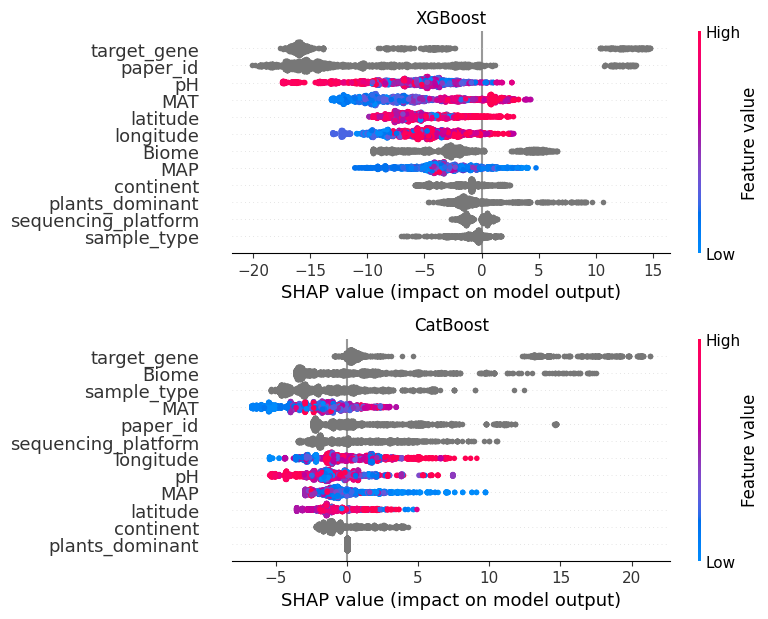

In [67]:
# Create a side-by-side plot
fig, axes = plt.subplots(2, 1, figsize=(25, 20))

# Save current figure to restore later
original_fig = plt.gcf()


plt.sca(axes[0])
shap.summary_plot(shap_xgb, X_train, show=False)
axes[0].set_title("XGBoost")

plt.sca(axes[1])
shap.summary_plot(shap_cat, X_train, show=False)
axes[1].set_title("CatBoost")

# Restore the original figure
plt.figure(original_fig.number)

plt.tight_layout()
plt.show()


#### LightGBM

Since we trained LightGBM in a binary relevance mode, we do feature importance for each label separately:

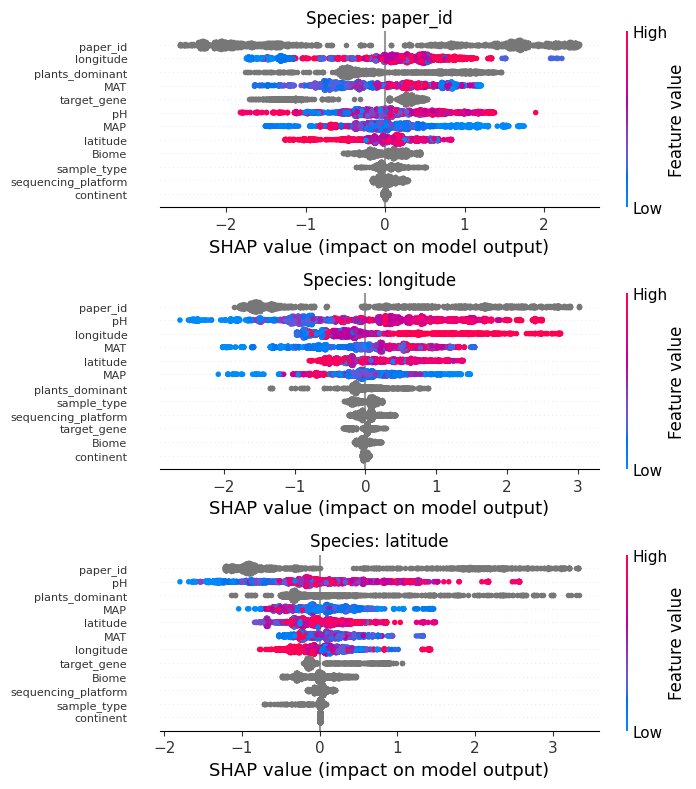

In [69]:
subsample = X_train
lgbm_shap_values = []
l = 3

for i in range(l):  # First three labels
    shap_values = calculate_shap_values(lgbm_models[i], subsample)
    lgbm_shap_values.append(shap_values)


fig, axes = plt.subplots(3, 1)

for i, shap_values in enumerate(lgbm_shap_values):
    plt.sca(axes[i])
    shap.summary_plot(shap_values, subsample, plot_size=(8, 8), show=False)
    plt.yticks(fontsize=8)
    axes[i].set_title(f"Species: {X_train.columns[i]}")


#plt.tight_layout()
plt.show()

From the plots above, we see that for both models, the paper_id is one of the influential features in the classification performances of these models. It is not surprising given that this dataset is build from pieces of information coming from very different sources. Another important variable for XGBoost and CatBoost is target gene.

We look closely at this variable. The plots below shows that there are three target genes with SSU being the dominating target gene:


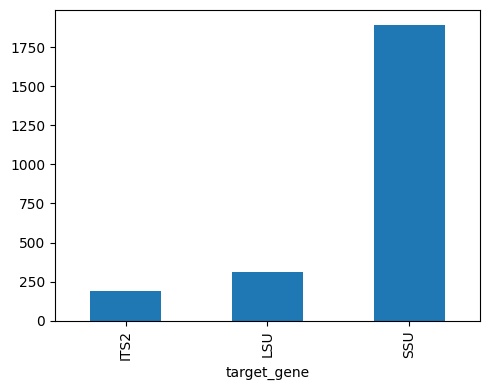

In [162]:
target_gene_species_count = pd.concat([df3["target_gene"],df3[Y_cols_selected].sum(axis=1).rename("species_richness")], axis=1)
target_gene_distri = target_gene_species_count.groupby("target_gene").size().rename("count")
target_gene_distri.plot(kind="bar", figsize=(5, 4))
plt.tight_layout()


The density plot below represent the species richness (we simply add up all the occurences for each example) distribution split by the target gene. SSU is associated with mostly rare species, whereas ITS2 has a large support: highly rich observations is associated uniquely with ITS2.

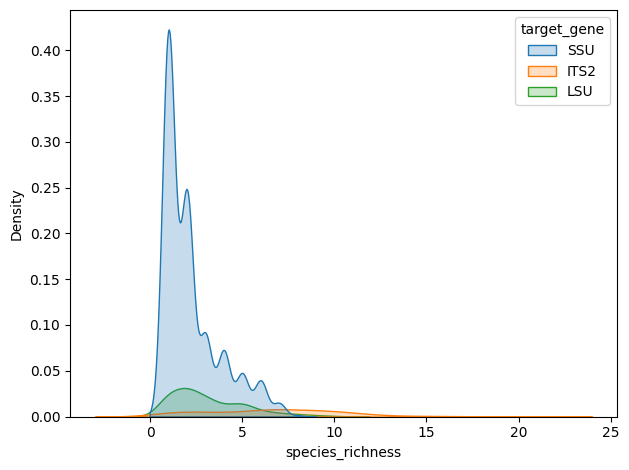

In [163]:
sns.kdeplot(data=target_gene_species_count, x='species_richness', hue='target_gene', fill=True, warn_singular=False)
plt.tight_layout()

CatBoost's performance was mostly influenced by categorical variables, but this leads to inferior performance to XGBoost. Mean annul temperature and pH are influential features for both models. It should be noted that these results are pertinent only for the given top k labels that we chose.

Feature importance for LightGBM:


In [ ]:
explainer = shap.TreeExplainer(model)
random_indices = np.random.choice(X_train.shape[0], size=num_samples, replace=False)
subsample = X_train.iloc[random_indices]
shap_values = explainer.shap_values(subsample)

aggregated_shap_values = shap_values.sum(axis=2)



### Prediction on several examples

We apply XGBoost to several examples in test data to illustrate its prediction: 1 means present.
Since we use only top k=20 frequent species, the rare species will not be classified.

We take some random example:

In [26]:
random_indices = np.random.choice(X_test.shape[0], size=3, replace=False)
random_indices

array([ 88,  80, 195])

In [37]:
sample = X_test.iloc[random_indices]
preds = xgbmodel.predict(sample)

First random example:

In [28]:
l = random_indices[0]

df3.loc[l, X_cols_selected]

,88
paper_id,Bunn_2014_3E43
longitude,-113.989
latitude,46.678
continent,North America
sample_type,root
Biome,shrubland
plants_dominant,Centaurea stoebe
target_gene,LSU
sequencing_platform,454Roche
MAP,483


Prediction:

In [29]:
pd.DataFrame({"true":Y_test.iloc[l], "predicted": preds[0,:]})

,true,predicted
Rhizophagus intraradices,0.0,0.0
Septoglomus viscosum,0.0,0.0
Funneliformis mosseae,0.0,0.0
Diversispora epigaea,0.0,0.0
Funneliformis caledonius,0.0,0.0
Gigaspora decipiens,1.0,1.0
Rhizophagus irregularis,0.0,0.0
Rhizophagus manihotis,0.0,0.0
Archaeospora_trappei,0.0,0.0
Diversispora trimurales,0.0,0.0


Second example:

In [30]:
l = random_indices[1]
df3.loc[l, X_cols_selected]

,80
paper_id,Bunn_2014_3E43
longitude,-117.753
latitude,47.742
continent,North America
sample_type,root
Biome,shrubland
plants_dominant,Centaurea stoebe
target_gene,LSU
sequencing_platform,454Roche
MAP,466


In [31]:
pd.DataFrame({"True":Y_test.iloc[l], "Predicted": preds[1,:]})

,True,Predicted
Rhizophagus intraradices,1.0,1.0
Septoglomus viscosum,0.0,0.0
Funneliformis mosseae,0.0,0.0
Diversispora epigaea,0.0,0.0
Funneliformis caledonius,0.0,0.0
Gigaspora decipiens,0.0,0.0
Rhizophagus irregularis,0.0,0.0
Rhizophagus manihotis,0.0,0.0
Archaeospora_trappei,0.0,0.0
Diversispora trimurales,0.0,0.0


Third example:

In [32]:
l = random_indices[2]
df3.loc[l, X_cols_selected]

,195
paper_id,Davison_2015_1GM
longitude,-104.617
latitude,50.7667
continent,North America
sample_type,root
Biome,grassland
plants_dominant,Hesperostipa comata
target_gene,SSU
sequencing_platform,454Roche
MAP,412


In [33]:
pd.DataFrame({"True":Y_test.iloc[l], "preds": preds[2,:]})

,True,preds
Rhizophagus intraradices,1.0,1.0
Septoglomus viscosum,1.0,0.0
Funneliformis mosseae,0.0,0.0
Diversispora epigaea,0.0,0.0
Funneliformis caledonius,1.0,1.0
Gigaspora decipiens,1.0,1.0
Rhizophagus irregularis,0.0,0.0
Rhizophagus manihotis,1.0,1.0
Archaeospora_trappei,1.0,1.0
Diversispora trimurales,0.0,0.0


As one can see most examples have very small number (mostly one or two) of species associated to it, i.e., the label matrix is sparse.

# References

<a id="ref1"></a>
[1] Větrovský, T., et al. "GlobalAMFungi: a global database of arbuscular mycorrhizal fungal occurrences from high‐throughput sequencing metabarcoding studies." New Phytologist 240.5 (2023).

<a id="ref2"></a>
[2] Sechidis, K., et al. "On the stratification of multi-label data." In Machine Learning and Knowledge Discovery in Databases: European Conference, ECML PKDD 2011, Athens, Greece, September 5-9, 2011, Proceedings, Part III 22 (pp. 145-158)

<a id="ref3"></a>
[3] Prokhorenkova, L., et al. "CatBoost: unbiased boosting with categorical features." Advances in neural information processing systems 31 (2018).

<a id="ref4"></a>
[4] Scott, M., and Lee Su-In. "A unified approach to interpreting model predictions." Advances in neural information processing systems 30 (2017).

